<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Classification
</h1>

### Full Name: Alireza Heidari
### Student ID: -

## Import needed libraries


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch import nn
from tqdm import tqdm
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
train_size = 48000
val_size = 60000 - train_size
train_ds,val_ds = random_split(train_set, [train_size, val_size])

In [6]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
classes = train_set.classes

**Display some images from dataset**

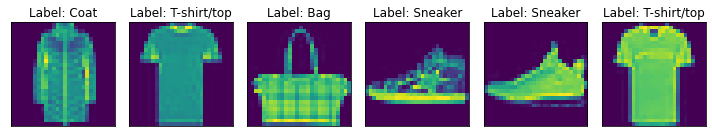

In [7]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [122]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
      
        self.fc_1 = nn.Sequential(
            nn.Linear(64*6*6, 600),
            nn.ReLU(),
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(600, 120),
            nn.ReLU(),
        )
        self.fc_3 = nn.Sequential(
            nn.Linear(120, 10),
            nn.Softmax(dim=1)
        )
        
        
    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)

        x = x.view(x.size(0), -1)

        x = self.fc_1(x)
        x = self.fc_2(x)
        out = self.fc_3(x)
        return out

In [123]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [124]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=600, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc_3): Sequential(
    (0): Linear(in_features=120, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

In [125]:
import torch.optim as optim

Learning_rate= 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=Learning_rate)

**Define number of epochs and path to save the best model**

In [126]:
epochs = 50
save_path="/content/cnn_model"

# Finally we will train our neural network

In [127]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [128]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_dataloader, unit="batch") as batches:
            epoch_loss = 0
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")
                # move to GPU
                data = data.to(device)
                target = target.to(device)

                # train 
                optimizer.zero_grad()

                out = cnn_model(data)
                loss = criterion(out, target)
                
                loss.backward()
                optimizer.step()

                epoch_loss += loss * data.size(0)
                acc = multi_acc(out, target)
                batches.set_postfix(train_loss = loss.item(), train_accuracy = acc.item()) # show loss and accuracy per batch of data

            epoch_loss /= len(train_dataloader.dataset)

        train_losses.append(float(epoch_loss.to('cpu')))


        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            y_true, y_pred = [], []
            for batch_idx, (data, target) in enumerate(val_dataloader):
                # move to GPU
                data = data.to(device)
                target = target.to(device)
        
                # validation
                out = model(data)
                valid_loss += criterion(out, target) * data.size(0)

            valid_loss /= len(val_dataloader.dataset)
        val_losses.append(float(valid_loss.to("cpu")))
        
        # print validation statistics 
        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, valid_loss))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 

    return model, train_losses, val_losses

**Train the model**

In [129]:
best_model, train_losses, val_losses = train_model(cnn_model, train_dataloader, val_dataloader, epochs, optimizer, criterion, device, save_path)

Epoch 1: 100%|██████████| 750/750 [00:20<00:00, 36.86batch/s, train_accuracy=86, train_loss=1.63]


Epoch: 1  Validation Loss: 1.600240
Validation loss decreased (inf --> 1.600240).  Saving model ...


Epoch 2: 100%|██████████| 750/750 [00:20<00:00, 37.14batch/s, train_accuracy=95, train_loss=1.54]


Epoch: 2  Validation Loss: 1.581686
Validation loss decreased (1.600240 --> 1.581686).  Saving model ...


Epoch 3: 100%|██████████| 750/750 [00:21<00:00, 35.39batch/s, train_accuracy=86, train_loss=1.61]


Epoch: 3  Validation Loss: 1.578881
Validation loss decreased (1.581686 --> 1.578881).  Saving model ...


Epoch 4: 100%|██████████| 750/750 [00:20<00:00, 36.23batch/s, train_accuracy=98, train_loss=1.49]


Epoch: 4  Validation Loss: 1.573143
Validation loss decreased (1.578881 --> 1.573143).  Saving model ...


Epoch 5: 100%|██████████| 750/750 [00:19<00:00, 37.79batch/s, train_accuracy=86, train_loss=1.6]


Epoch: 5  Validation Loss: 1.563423
Validation loss decreased (1.573143 --> 1.563423).  Saving model ...


Epoch 6: 100%|██████████| 750/750 [00:20<00:00, 37.11batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 6  Validation Loss: 1.565043


Epoch 7: 100%|██████████| 750/750 [00:20<00:00, 37.38batch/s, train_accuracy=84, train_loss=1.62]


Epoch: 7  Validation Loss: 1.561176
Validation loss decreased (1.563423 --> 1.561176).  Saving model ...


Epoch 8: 100%|██████████| 750/750 [00:20<00:00, 37.06batch/s, train_accuracy=89, train_loss=1.57]


Epoch: 8  Validation Loss: 1.562761


Epoch 9: 100%|██████████| 750/750 [00:20<00:00, 36.98batch/s, train_accuracy=94, train_loss=1.52]


Epoch: 9  Validation Loss: 1.558345
Validation loss decreased (1.561176 --> 1.558345).  Saving model ...


Epoch 10: 100%|██████████| 750/750 [00:20<00:00, 37.43batch/s, train_accuracy=89, train_loss=1.57]


Epoch: 10  Validation Loss: 1.556664
Validation loss decreased (1.558345 --> 1.556664).  Saving model ...


Epoch 11: 100%|██████████| 750/750 [00:20<00:00, 36.70batch/s, train_accuracy=97, train_loss=1.5]


Epoch: 11  Validation Loss: 1.553063
Validation loss decreased (1.556664 --> 1.553063).  Saving model ...


Epoch 12: 100%|██████████| 750/750 [00:19<00:00, 38.23batch/s, train_accuracy=92, train_loss=1.55]


Epoch: 12  Validation Loss: 1.555706


Epoch 13: 100%|██████████| 750/750 [00:20<00:00, 37.22batch/s, train_accuracy=92, train_loss=1.54]


Epoch: 13  Validation Loss: 1.548372
Validation loss decreased (1.553063 --> 1.548372).  Saving model ...


Epoch 14: 100%|██████████| 750/750 [00:20<00:00, 37.08batch/s, train_accuracy=95, train_loss=1.52]


Epoch: 14  Validation Loss: 1.549554


Epoch 15: 100%|██████████| 750/750 [00:20<00:00, 37.26batch/s, train_accuracy=94, train_loss=1.53]


Epoch: 15  Validation Loss: 1.551937


Epoch 16: 100%|██████████| 750/750 [00:19<00:00, 38.15batch/s, train_accuracy=91, train_loss=1.55]


Epoch: 16  Validation Loss: 1.548682


Epoch 17: 100%|██████████| 750/750 [00:19<00:00, 37.84batch/s, train_accuracy=98, train_loss=1.49]


Epoch: 17  Validation Loss: 1.546733
Validation loss decreased (1.548372 --> 1.546733).  Saving model ...


Epoch 18: 100%|██████████| 750/750 [00:19<00:00, 37.73batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 18  Validation Loss: 1.548546


Epoch 19: 100%|██████████| 750/750 [00:20<00:00, 37.26batch/s, train_accuracy=97, train_loss=1.5]


Epoch: 19  Validation Loss: 1.549087


Epoch 20: 100%|██████████| 750/750 [00:20<00:00, 35.72batch/s, train_accuracy=92, train_loss=1.54]


Epoch: 20  Validation Loss: 1.545711
Validation loss decreased (1.546733 --> 1.545711).  Saving model ...


Epoch 21: 100%|██████████| 750/750 [00:20<00:00, 37.47batch/s, train_accuracy=95, train_loss=1.49]


Epoch: 21  Validation Loss: 1.550338


Epoch 22: 100%|██████████| 750/750 [00:19<00:00, 37.87batch/s, train_accuracy=97, train_loss=1.5]


Epoch: 22  Validation Loss: 1.548434


Epoch 23: 100%|██████████| 750/750 [00:19<00:00, 37.62batch/s, train_accuracy=92, train_loss=1.55]


Epoch: 23  Validation Loss: 1.550112


Epoch 24: 100%|██████████| 750/750 [00:20<00:00, 36.59batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 24  Validation Loss: 1.548624


Epoch 25: 100%|██████████| 750/750 [00:20<00:00, 36.71batch/s, train_accuracy=97, train_loss=1.49]


Epoch: 25  Validation Loss: 1.549341


Epoch 26: 100%|██████████| 750/750 [00:21<00:00, 35.08batch/s, train_accuracy=100, train_loss=1.46]


Epoch: 26  Validation Loss: 1.544588
Validation loss decreased (1.545711 --> 1.544588).  Saving model ...


Epoch 27: 100%|██████████| 750/750 [00:20<00:00, 36.79batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 27  Validation Loss: 1.546611


Epoch 28: 100%|██████████| 750/750 [00:19<00:00, 37.57batch/s, train_accuracy=94, train_loss=1.52]


Epoch: 28  Validation Loss: 1.544405
Validation loss decreased (1.544588 --> 1.544405).  Saving model ...


Epoch 29: 100%|██████████| 750/750 [00:19<00:00, 37.96batch/s, train_accuracy=97, train_loss=1.49]


Epoch: 29  Validation Loss: 1.547865


Epoch 30: 100%|██████████| 750/750 [00:20<00:00, 36.32batch/s, train_accuracy=92, train_loss=1.53]


Epoch: 30  Validation Loss: 1.546378


Epoch 31: 100%|██████████| 750/750 [00:20<00:00, 36.73batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 31  Validation Loss: 1.544629


Epoch 32: 100%|██████████| 750/750 [00:20<00:00, 36.81batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 32  Validation Loss: 1.545000


Epoch 33: 100%|██████████| 750/750 [00:19<00:00, 37.89batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 33  Validation Loss: 1.549018


Epoch 34: 100%|██████████| 750/750 [00:20<00:00, 36.57batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 34  Validation Loss: 1.542539
Validation loss decreased (1.544405 --> 1.542539).  Saving model ...


Epoch 35: 100%|██████████| 750/750 [00:20<00:00, 37.42batch/s, train_accuracy=94, train_loss=1.53]


Epoch: 35  Validation Loss: 1.542456
Validation loss decreased (1.542539 --> 1.542456).  Saving model ...


Epoch 36: 100%|██████████| 750/750 [00:20<00:00, 36.78batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 36  Validation Loss: 1.544625


Epoch 37: 100%|██████████| 750/750 [00:20<00:00, 37.41batch/s, train_accuracy=97, train_loss=1.49]


Epoch: 37  Validation Loss: 1.544894


Epoch 38: 100%|██████████| 750/750 [00:20<00:00, 36.99batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 38  Validation Loss: 1.545715


Epoch 39: 100%|██████████| 750/750 [00:19<00:00, 38.02batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 39  Validation Loss: 1.545886


Epoch 40: 100%|██████████| 750/750 [00:19<00:00, 38.24batch/s, train_accuracy=94, train_loss=1.53]


Epoch: 40  Validation Loss: 1.546900


Epoch 41: 100%|██████████| 750/750 [00:20<00:00, 37.18batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 41  Validation Loss: 1.544221


Epoch 42: 100%|██████████| 750/750 [00:21<00:00, 35.48batch/s, train_accuracy=94, train_loss=1.52]


Epoch: 42  Validation Loss: 1.548459


Epoch 43: 100%|██████████| 750/750 [00:20<00:00, 37.16batch/s, train_accuracy=95, train_loss=1.5]


Epoch: 43  Validation Loss: 1.543466


Epoch 44: 100%|██████████| 750/750 [00:19<00:00, 37.63batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 44  Validation Loss: 1.543001


Epoch 45: 100%|██████████| 750/750 [00:19<00:00, 37.93batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 45  Validation Loss: 1.545126


Epoch 46: 100%|██████████| 750/750 [00:19<00:00, 37.89batch/s, train_accuracy=95, train_loss=1.51]


Epoch: 46  Validation Loss: 1.542585


Epoch 47: 100%|██████████| 750/750 [00:20<00:00, 37.00batch/s, train_accuracy=100, train_loss=1.46]


Epoch: 47  Validation Loss: 1.540693
Validation loss decreased (1.542456 --> 1.540693).  Saving model ...


Epoch 48: 100%|██████████| 750/750 [00:20<00:00, 36.26batch/s, train_accuracy=98, train_loss=1.48]


Epoch: 48  Validation Loss: 1.545634


Epoch 49: 100%|██████████| 750/750 [00:20<00:00, 36.92batch/s, train_accuracy=94, train_loss=1.52]


Epoch: 49  Validation Loss: 1.544342


Epoch 50: 100%|██████████| 750/750 [00:20<00:00, 37.37batch/s, train_accuracy=100, train_loss=1.46]


Epoch: 50  Validation Loss: 1.541348


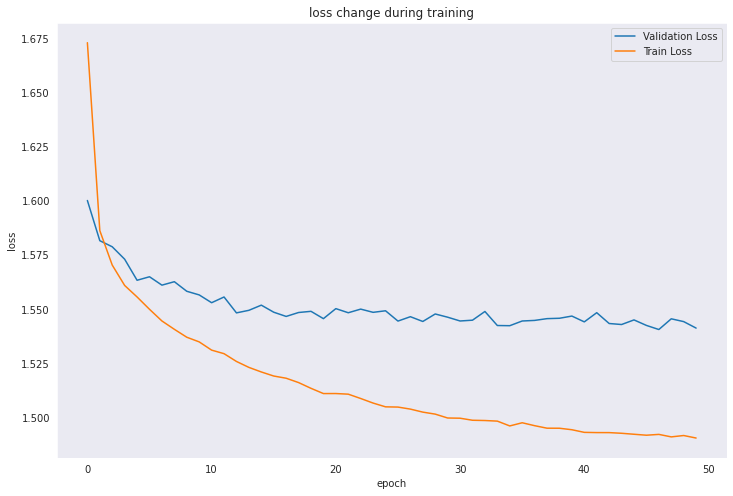

In [130]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [131]:
def predict(images, model):
    model.eval()
    _, predicted = torch.max(model(images), 1)
    return predicted

**Accuracy Result on Test Data**

In [133]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        predicted = predict(images.to(device), best_model)
        for x in predicted.cpu().numpy(): y_pred_list.append(x)
        for x in labels.cpu().numpy(): y_true_list.append(x)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


**Classification report**

In [134]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.91      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.87      0.87      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.88      0.86      0.87      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.79      0.72      0.75      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.97      0.99      0.98      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Displaying a random set of images from test data**

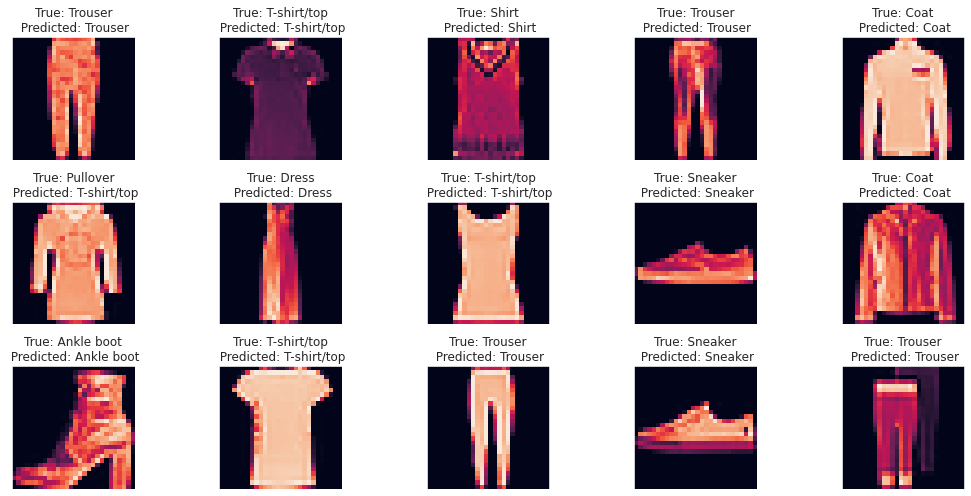

In [135]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images.to(device),cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()